In [1]:
from tqdm import tqdm
import copy
import time
import functools
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score


In [2]:
def timeit(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()  
        result = func(*args, **kwargs)  
        end_time = time.time()  
        execution_time = end_time - start_time  
        print(f"Function '{func.__name__}' executed in {execution_time:.4f} seconds")
        return result
    return wrapper

In [3]:
# check if runs on Apple Silicon efficiently

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    raise Exception("MPS not available")

else:
    device = torch.device("mps")
    print("MPS enabled")

MPS enabled


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-04-10,16.85,17.240,14.00,14.01,14.01,2408700
1,2014-04-11,13.74,13.904,12.02,13.00,13.00,197200
2,2014-04-14,12.96,13.890,12.71,13.60,13.60,36500
3,2014-04-15,14.44,14.440,13.10,13.39,13.39,40500
4,2014-04-16,13.40,13.470,13.03,13.20,13.20,32300
...,...,...,...,...,...,...,...
1500,2020-03-26,2.73,2.910,2.67,2.79,2.79,290700
1501,2020-03-27,2.79,2.810,2.55,2.67,2.67,168300
1502,2020-03-30,2.71,2.770,2.40,2.76,2.76,323700
1503,2020-03-31,2.75,2.980,2.70,2.89,2.89,231900


# Load Dataset

In [4]:
df = pd.read_csv('data/archive/stocks/ADMS.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-04-10,16.85,17.240,14.00,14.01,14.01,2408700
1,2014-04-11,13.74,13.904,12.02,13.00,13.00,197200
2,2014-04-14,12.96,13.890,12.71,13.60,13.60,36500
3,2014-04-15,14.44,14.440,13.10,13.39,13.39,40500
4,2014-04-16,13.40,13.470,13.03,13.20,13.20,32300
...,...,...,...,...,...,...,...
1500,2020-03-26,2.73,2.910,2.67,2.79,2.79,290700
1501,2020-03-27,2.79,2.810,2.55,2.67,2.67,168300
1502,2020-03-30,2.71,2.770,2.40,2.76,2.76,323700
1503,2020-03-31,2.75,2.980,2.70,2.89,2.89,231900


In [5]:
X = df.drop(columns=['Close', 'Date', 'Adj Close'])
y = df['Close']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

#  Linear Regression

In [10]:
lr_model = LinearRegression()
history = lr_model.fit(X_train, y_train)
# print(lr_model.score(X_test, y_test))


In [11]:
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

0.13638723674317882

In [12]:
def walk_forward_validation(model, train, test):
    history = train.copy()
    predictions = []

    for t in range(len(test)):
        # Define the training data
        train_X = history[['Open', 'High', 'Low', 'Volume']].values
        train_y = history['Close'].values
        
        # Fit the model
        model.fit(train_X, train_y)
        
        # Make a prediction
        test_X = test.iloc[t][['Open', 'High', 'Low', 'Volume']].values.reshape(1, -1)
        yhat = model.predict(test_X)
        predictions.append(yhat[0])
        
        # Add the observation to the history using pd.concat
        history = pd.concat([history, test.iloc[[t]]])
    
    return predictions

In [13]:
predictions_lr = walk_forward_validation(lr_model, train, test)

In [14]:
mse = mean_squared_error(test['Close'], predictions_lr)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.01451735770612803


In [15]:
def plot_results(df, test, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Close'], label='Actual')
    plt.plot(test['Date'], predictions, label='Predicted', linestyle='--')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

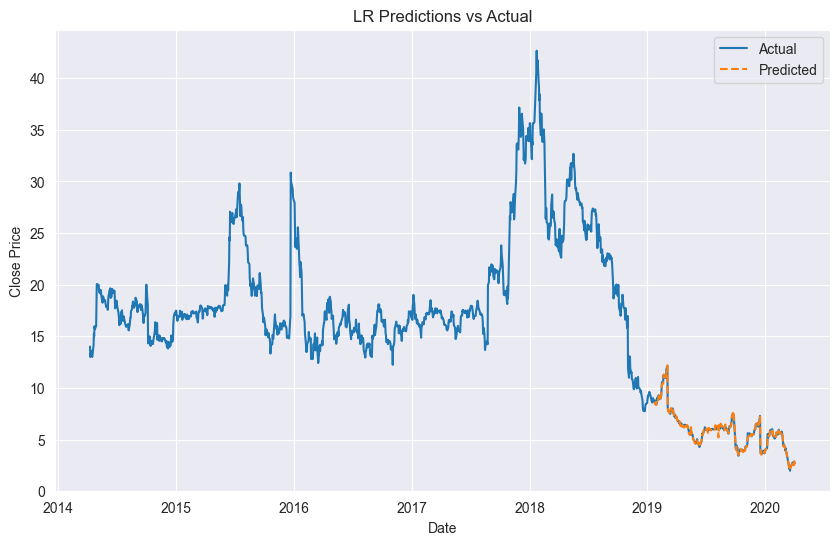

In [17]:
plot_results(df, test, predictions_lr, 'LR')

# RandomForestRegressor

In [19]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
predictions_rf = walk_forward_validation(rf_model, train, test)


In [64]:
mse_rf = mean_squared_error(test['Close'], predictions_rf)
print(f'RandomForestRegressor Mean Squared Error: {mse_rf}')

RandomForestRegressor Mean Squared Error: 0.03995827728389956


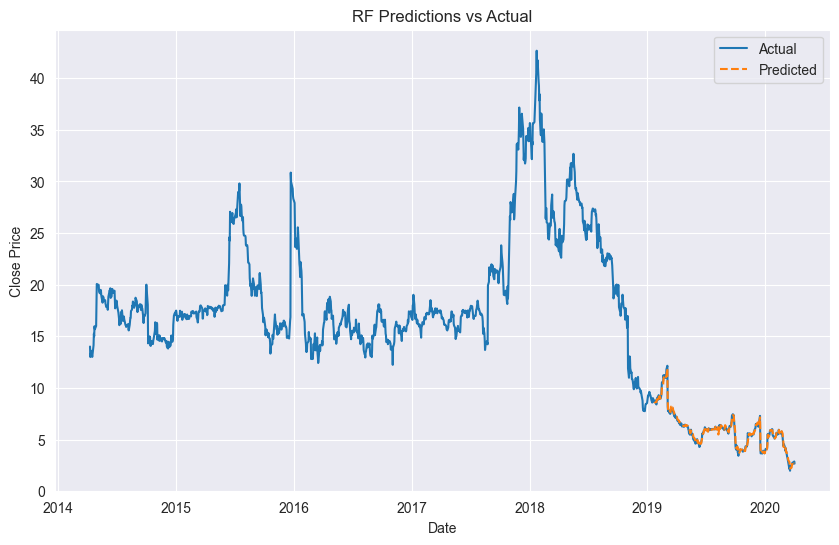

In [69]:
plot_results(df, test, predictions_rf, 'RF')

# LSTM-DNN

In [20]:
class LSTM_DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_DNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 50)
        self.fc2 = nn.Linear(50, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# 1D-CNN-LSTM-DNN